In [4]:
import tensorflow as tf
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import copy


In [271]:
class Dense:
    def __init__(self,inputAmnt: int, outputAmnt: int,w = None,b = None):
        if not w:
            self.w = 10*np.random.random_sample(size=(outputAmnt,inputAmnt))
        else:
            self.w = w
        self.allW = []
        if not b:
            self.b =  10*np.random.random_sample(size=(outputAmnt,1))
        else:
            self.b = b
        self.allB = []
        self.a = None
    def ein(self,x,y):
        return np.einsum("i,j -> ij",np.transpose(x)[0],np.transpose(y)[0])
    def feedfoward(self,a_0):
        self.a = a_0
        return  self.w @ a_0 + self.b

    def backprop(self, alpha,dz,paramMemory):
        if(paramMemory):
            self.allW.append(ndarray.copy(self.w))
            self.allB.append(ndarray.copy(self.b))
        self.b -= alpha * dz
        self.w -= alpha * self.ein(dz,self.a)
        return np.transpose(self.w) @ dz
class softmax:
    def __init__(self):
        self.a_0 = None
    def feedfoward(self,a_0):
        self.a_0 = a_0
        return a_0/(np.sum(a_0)+1e-10)
    
    def backprop(self,alpha,dz,paramMemory):
        summation = np.sum(self.a_0) + 1e-10
        return dz * (1/summation-self.a_0/(summation**2))
class act:
    def __init__(self):
        self.a_0 = None
        self.mask = None
        self.mask1 = None
    def feedfoward(self,a_0):
        self.a_0 = a_0
        self.mask = (a_0 >= 0)
        self.mask1 = (a_0 < 0)
        a = np.zeros_like(a_0)
        a[self.mask] = self.a_0[self.mask]+1
        a[self.mask1] = np.exp(self.a_0[self.mask1])
        return a
    
    def backprop(self,alpha,dz,paramMemory):
        a = np.zeros_like(self.a_0)
        a[self.mask] = 1
        a[self.mask1] = np.exp(self.a_0[self.mask1])
        return dz * a
class ANN:
    def __init__(self,*layers):
        self.layers = list(layers)
    def compute(self,inp):
        output = inp
        for layer in self.layers:
            output = layer.feedfoward(output)
        return output
    def gradDescent(self,inputs,outputs,lr,epochs,paramMemory = False,returnAcc = False):
        acc = []
        for i in range(epochs):
            for (input,output) in zip(inputs,outputs):
                dz = 2*(self.compute(input)-output)
                for layer in self.layers[::-1]:
                    dz = layer.backprop(lr,dz,paramMemory)
            if(returnAcc):
                acc.append(self.testAcc2(inputs,outputs))
        return acc
    def testAccuracy(self,inputs,outputs):
        error = 0
        for(input, output) in zip(inputs,outputs):
            if(np.argmax(self.compute(input)) != output):
                error +=1
        return 1-error/len(inputs)
    def testAcc2(self,inputs,outputs):
        error = 0
        for(input, output) in zip(inputs,outputs):
            if(np.argmax(self.compute(input)) != np.argmax(output)):
                error +=1
        return 1-error/len(inputs)

In [223]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1,1) / 255  # input for training
x_test = x_test.reshape(x_test.shape[0], -1,1) / 255  # input for testing
y_train = y_train.reshape(60_000,1)
def encode(input):
    z = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    z[0][input] = 1
    return np.transpose(z)
output_test = np.apply_along_axis(encode,1,y_train)


In [272]:
model = ANN(Dense(784,15),act(),softmax(),Dense(15,10),act(),softmax())

In [274]:
x = model.gradDescent(x_train,output_test,5,5,False,True)

In [290]:
params = np.load("params.npz")

In [295]:
y = model.gradDescent(x_train,output_test,lr=5,epochs=10,paramMemory=False,returnAcc=True)

In [296]:
x += y
print(x)

[0.10441666666666671, 0.14605, 0.23053333333333337, 0.3122166666666667, 0.6048666666666667, 0.8010166666666667, 0.8587666666666667, 0.8801166666666667, 0.8916166666666667, 0.8985, 0.9036666666666666, 0.9051, 0.9071833333333333, 0.9084, 0.9088666666666667, 0.9090666666666667, 0.90965, 0.9111833333333333, 0.91325, 0.9143666666666667, 0.9152166666666667, 0.9164, 0.9167333333333333, 0.9173666666666667, 0.9176666666666666]


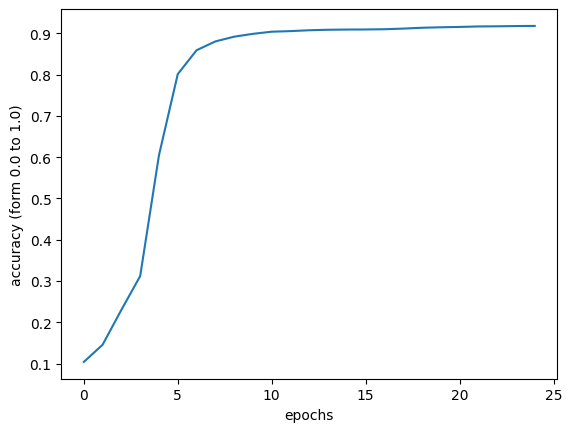

In [297]:
plt.plot(x)
plt.ylabel("accuracy (form 0.0 to 1.0)")
plt.xlabel("epochs")
plt.show()

In [1]:
imageIndex = 1009
x = x_train[imageIndex].reshape(28,28)
plt.imshow(x,cmap='gray')
plt.title(f"Label: {y_train[imageIndex]}")
plt.axis('off')
plt.show()
print(f"ai prediction {np.argmax(model.compute(x_train[imageIndex]))}")

NameError: name 'x_train' is not defined

In [289]:
z0 = model.layers[0]
z3 = model.layers[3]
np.savez("params.npz",w0=z0.w,b0=z0.b,w1=z3.w,b1=z3.b)
#saved the model (current is 90 pct, do not save unless you have found a better one)
#archetecture is Dense, act,softmax,Dense,act,softmax